# Behavioral_pattern analysis

#### 한글폰트 설정

In [ ]:
# 추후 평가 모델을 neg_mean_absolute_percentage_error로 사용하기 위해서 scikit-learn==0.24 버전 설치 및 런타임 재시작이 필요합니다. 
# 이에, 서두에 기재하였습니다. 
!pip install scikit-learn==0.24

In [29]:
import json
import time

import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(["seaborn-whitegrid"])
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [30]:
# plt 한글 깨짐 현상을 해결하기 위한 코드입니다. 
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') 

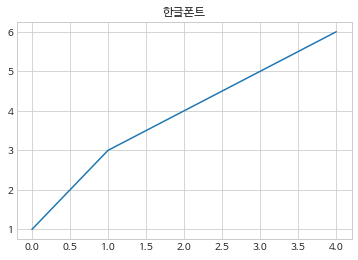

In [31]:
# 한글폰트 깨짐현상 테스트
pd.Series([1,3,4,5,6]).plot(title="한글폰트");

## **🍀 DATA OVERVIEW**
- AI 허브에서 제공하는 스마트폰 앱/웹 로그 데이터셋
- 수집 기간 :  2018.10월- 2018.11월(주)   
- 수집 방법 : UsageStat API를 활용해 수집된 앱 사용 내역
- 수집 대상 : Android 6.0.0 이상 사용자
- 수집 유형 : json type 데이터 
- feature : 
  * timestamp : 핸드폰에서 어플 사용할 때마다 시간이 측정됨  
  * utc offset : 시간 기준으로 한국에서 사용했는지 해외에서 사용했는지를 나타내는 지표  
  * subject_id : 실험에 참여한 인원들  
  * source_type : 핸드폰 앱 사용 기록이므로 핸드폰 1종류만 기재됨    
  * source_info	: 핸드폰에 대한 상세정보(모델명, 버전)    
  * package_name : 핸드폰에서 사용한 어플에 대한 경로값 	    
  * name : 사용한 어플 이름   
  * is_system_app	: 핸드폰 내에 설치되어 있는 앱  
  * is_updated_system_app	: 플레이 스토어 등을 통해서 추가적으로 설치된 앱  
  * type : 사용자가 어떤 행동을 하였는지 기록(대분류로 분류되어 있으나, 사용한 앱에 따라 별도의 분류가 필요할 것으로 사료됨)  

#### 데이터 로드 및 확인 

In [32]:
# 기본적인 warning을 제거하기 위한 코드 
import warnings
warnings.filterwarnings("ignore")

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 구글 드라이브 경로 
cd /content/drive/MyDrive/data

In [ ]:
# 경로 확인 및 데이터 확인 
ls

In [36]:
# 데이터 load
f1 = open("스마트폰_로그_데이터셋.json", encoding="UTF-8")

json1 = json.loads(f1.read())

In [37]:
# 데이터 확인 
json1[:2]

[{'id': 4,
  'is_system_app': 0,
  'is_updated_system_app': 0,
  'name': 'BAND',
  'package_name': 'com.nhn.android.band',
  'source_info': 'samsung-SM-G928S-7.0',
  'source_type': 'PHONE',
  'subject_id': '2099efc17d719274924b8c81543c7972',
  'timestamp': 1540790989686,
  'type': 'USER_INTERACTION',
  'utcoffset': 9},
 {'id': 7,
  'is_system_app': 0,
  'is_updated_system_app': 0,
  'name': 'BAND',
  'package_name': 'com.nhn.android.band',
  'source_info': 'samsung-SM-G928S-7.0',
  'source_type': 'PHONE',
  'subject_id': '2099efc17d719274924b8c81543c7972',
  'timestamp': 1540790994228,
  'type': 'MOVE_TO_FOREGROUND',
  'utcoffset': 9}]

In [38]:
# pd.DataFrame으로 변경 
df1 = pd.DataFrame(json1)
df1 =  df1.drop(columns=["id"])
df1.head()

timestamp  utcoffset                        subject_id source_type  \
0  1540790989686          9  2099efc17d719274924b8c81543c7972       PHONE   
1  1540790994228          9  2099efc17d719274924b8c81543c7972       PHONE   
2  1540790994420          9  2099efc17d719274924b8c81543c7972       PHONE   
3  1540790994486          9  2099efc17d719274924b8c81543c7972       PHONE   
4  1540791001635          9  2099efc17d719274924b8c81543c7972       PHONE   

            source_info          package_name  name  is_system_app  \
0  samsung-SM-G928S-7.0  com.nhn.android.band  BAND              0   
1  samsung-SM-G928S-7.0  com.nhn.android.band  BAND              0   
2  samsung-SM-G928S-7.0  com.nhn.android.band  BAND              0   
3  samsung-SM-G928S-7.0  com.nhn.android.band  BAND              0   
4  samsung-SM-G928S-7.0  com.nhn.android.band  BAND              0   

   is_updated_system_app                type  
0                      0    USER_INTERACTION  
1                      0  MOVE_TO_FOREGROUND  
2                      0  MOVE_TO_BACKGROUND  
3                      0  MOVE_TO_FOREGROUND  
4                      0  MOVE_TO_BACKGROUND

In [39]:
df1.shape

(1588338, 10)

#### 데이터 전처리 및 EDA

In [40]:
# 데이터 확인 ( 카테고리, 결측치, 타입 )
checking = df1.nunique().to_frame(name="unique")
checking["null"] =df1.isnull().sum()
checking["dtypes"] = df1.dtypes
checking.T

timestamp utcoffset subject_id source_type source_info package_name  \
unique   1583089         2         33           1          27          864   
null           0         0          0           0           0            0   
dtypes     int64     int64     object      object      object       object   

          name is_system_app is_updated_system_app    type  
unique     833             2                     2       6  
null         0             0                     0       0  
dtypes  object         int64                 int64  object

In [41]:
# 한자로 기재된 데이터 수정하였습니다. 
df1["name"] = df1["name"].replace("微信", "위챗")

In [42]:
# subject_id는 수집 대상 인원을 암호화된 것으로 식별하기 쉽게 0~32로 라벨링을 진행하였습니다. 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df1["subject_id"] = encoder.fit_transform(df1["subject_id"])
df1["subject_id"].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [43]:
# 해외에서 사용한 이력도 645개로 관찰됩니다. 분석에는 크게 이슈가 없을 것으로 사료되어 그대로 진행하겠습니다. 
df1[["utcoffset"]].value_counts().to_frame().T
df1 = df1[df1["utcoffset"] == 9]

In [44]:
# 데이터의 type을 살펴보겠습니다. 
df1[["type"]].value_counts().to_frame()

0
type                        
MOVE_TO_FOREGROUND    739080
MOVE_TO_BACKGROUND    737490
USER_INTERACTION       93212
CONFIGURATION_CHANGE   17215
SHORTCUT_INVOCATION      498
NONE                     198

MOVE_TO_BACKGROUND과 NONE은 개인의 활동으로 보기는 어려우므로 추후 데이터 정제 시, 해당 컬럼은 제거하도록 하겠습니다. (MOVE_TO_BACKGROUND는 MOVE_TO_FOREGROUND 시, 함께 실행되는 로그 측정 단위라고 생각하시면 됩니다.)  
또한, CONFIGURATION_CHANGE와 NONE의 경우, 참여자가 직접적으로 작동한 것으로 볼 수 없기 때문에 제외하도록 하겠습니다. 

##### df1_action 데이터 생성

In [94]:
# 실제 활동으로 예측되는 row들만 df1_action이라는 데이터로 저장해주도록 하겠습니다. 
action = ['MOVE_TO_FOREGROUND', 'USER_INTERACTION', 'SHORTCUT_INVOCATION']
df1_action = df1[df1.type.isin(action)]

In [95]:
# row가 대폭 감소하는 것을 관찰하였습니다. 
df1.shape, df1_action.shape

((1587693, 10), (832790, 10))

In [96]:
# 2, 18번 사용자가 압도적으로 많은 사용량이 관측되었으며, 30번 참여자는 너무 미비한 사용량이 관측되었습니다. 
# 추후 분석을 할때 30번 사용자를 주의하여 분석하도록 하겠습니다.  
print(df1_action[["subject_id"]].value_counts().to_frame().T)

subject_id     2      18     25     27     1      15     17     20     21  \
0           67889  66961  40809  39535  39296  38895  34940  33705  30457   

subject_id     9      23     12     6      19     3      14     22     0   \
0           29841  29788  27705  27114  26960  26353  25796  23131  21083   

subject_id     4      32     8      26     7      13     11     29     31  \
0           19600  18312  17868  15670  15288  14514  14463  14359  13727   

subject_id     24     28     5      10    16  30  
0           13207  13021  12357  11060  9066  20  


In [97]:
# 핸드폰 취향에 따라서 사용자의 패턴이 달라질 수 있으므로, 큰 카테고리 ( 삼성, LG, google 등)으로 범위화 하고자 합니다. 
df1_action[["source_info"]].value_counts().to_frame().T

source_info samsung-SM-G950N-8.0.0 samsung-SM-G930K-8.0.0 Sony-G8141-8.0.0  \
0                           102867                  73411            67889   

source_info samsung-SM-G965N-8.0.0 LGE-LG-F800K-8.0.0 samsung-SM-N950N-8.0.0  \
0                            67537              66961                  62096   

source_info samsung-SM-G930S-8.0.0 LGE-LGM-V300K-8.0.0 samsung-SM-A710S-7.0  \
0                            46973               38895                34940   

source_info samsung-SM-G960U1-8.0.0 samsung-SM-N920S-7.0  \
0                             30457                27705   

source_info samsung-SM-N910K-6.0.1 samsung-SM-G960N-8.0.0  \
0                            25796                  21083   

source_info samsung-SM-N960N-8.1.0 samsung-SM-G935S-8.0.0  \
0                            20198                  19600   

source_info samsung-SM-N935S-8.0.0 samsung-SM-N920K-7.0  \
0                            18312                17868   

source_info samsung-SM-G955N-8.0.0 LGE-LGM-G600S-8.0.0 LGE-LG-F700L-8.0.0  \
0                            15670               14463              14359   

source_info samsung-SM-G920S-6.0.1 LGE-LGM-X320L-7.0 samsung-SM-G928S-7.0  \
0                            13207             11060                10288   

source_info samsung-SM-N950N-7.1.1 Xiaomi-Redmi Note 5-8.1.0  \
0                             9066                      2069   

source_info LGE-LGM-G600K-8.0.0  
0                            20

In [98]:
# 핸드폰 카테고리 최소화 작업 ( 27개 -> 5개로 축소 )
df1_action["source_info"][df1_action.source_info.str.contains("samsung")] = "SAMSUNG"
df1_action["source_info"][df1_action.source_info.str.contains("LGE")] = "LG"
df1_action["source_info"][df1_action.source_info.str.contains("Sony")] = "Sony"
df1_action["source_info"][df1_action.source_info.str.contains("Xiaomi")] = "Xiaomi"
df1_action["source_info"][df1_action.source_info.str.contains("Google")] = "Google"

위처럼 핸드폰에서 앱을 시작하면서 변화되는 모든 순간을 시간으로 기록되는 것을 관찰할 수 있습니다. 또한, 0.01초 단위로 로그데이터가 기록되다보니 초단위로 데이터를 살펴보았을 때 중복되는 데이터가 있습니다. 
이러한 데이터들은 중복으로 간주하고 제거해주도록 하겠습니다. 

In [99]:
# 데이터 변경 여부 확인 
df1_action

timestamp  utcoffset  subject_id source_type source_info  \
0        1540790989686          9           5       PHONE     SAMSUNG   
1        1540790994228          9           5       PHONE     SAMSUNG   
3        1540790994486          9           5       PHONE     SAMSUNG   
5        1540791001652          9           5       PHONE     SAMSUNG   
7        1540791007590          9           5       PHONE     SAMSUNG   
...                ...        ...         ...         ...         ...   
1588329  1540649186180          9          29       PHONE          LG   
1588331  1540649186582          9          29       PHONE          LG   
1588333  1540649490062          9          29       PHONE          LG   
1588334  1540649490954          9          29       PHONE          LG   
1588336  1540649493133          9          29       PHONE          LG   

                    package_name    name  is_system_app  \
0           com.nhn.android.band    BAND              0   
1           com.nhn.android.band    BAND              0   
3           com.nhn.android.band    BAND              0   
5           com.nhn.android.band    BAND              0   
7           com.nhn.android.band    BAND              0   
...                          ...     ...            ...   
1588329  com.fitbit.FitbitMobile  Fitbit              0   
1588331        com.lge.launcher3     기본홈              1   
1588333     com.xiaomi.hm.health   Mi 피트              0   
1588334        com.lge.launcher3     기본홈              1   
1588336       com.android.chrome  Chrome              1   

         is_updated_system_app                type  
0                            0    USER_INTERACTION  
1                            0  MOVE_TO_FOREGROUND  
3                            0  MOVE_TO_FOREGROUND  
5                            0  MOVE_TO_FOREGROUND  
7                            0  MOVE_TO_FOREGROUND  
...                        ...                 ...  
1588329                      0  MOVE_TO_FOREGROUND  
1588331                      0  MOVE_TO_FOREGROUND  
1588333                      0    USER_INTERACTION  
1588334                      0  MOVE_TO_FOREGROUND  
1588336                      1  MOVE_TO_FOREGROUND  

[832790 rows x 10 columns]

In [100]:
# 어떤 앱들이 있는지 살펴보겠습니다. 
df1_action.name.value_counts()

카카오톡                             226621
트위터                               76562
Samsung Experience 홈              67635
ABC Platform                      31018
캐시워크                              23904
                                  ...  
Moon+ Reader                          1
무료 공학용 계산기                            1
영풍문고                                  1
삼성 TTS 엔진                             1
com.sec.android.app.wfdbroker         1
Name: name, Length: 832, dtype: int64

현재 app의 수는 832개로 너무 많은 카테고리가 존재합니다. 이에, 이를 대장르와 장르로 묶어주는 작업을 해보겠습니다. 객관적인 범주를 위해 해당 앱들을 구글 스토어에 검색한 후 크롤링을 통해서 장르를 가져오도록 하겠습니다. 

##### genre 크롤링 및 카테고리화 

In [ ]:
# selenium을 활용하여 크롤링을 진행하도록 하겠습니다. 
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

In [102]:
app_list = df1_action.name.unique()

from selenium import webdriver
from time import sleep
from IPython.display import clear_output

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # 백그라운드에서 실행이 될 수 있도록 합니다. 
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)
driver.implicitly_wait(2)


genre_dict = {}
error_list = []

for i, key_word in enumerate(app_list):
    driver.get('https://play.google.com/store/apps')

    try:
        clear_output() # 클리어 아웃을 해주지 않으며, 주루룩 나오기 때문에 clear_output을 넣어주어 진행결과를 확인 합니다. 
        print(f'{i+1}/832') #len(app_list) = 832
        driver.find_element_by_xpath('//*[@id="gbqfq"]').send_keys(f'{key_word}' + '\n') #\n을 같이 써줬기에 페이지로 한번에 이동함
        selected_tag_a = driver.find_element_by_xpath('//*[@id="fcxH9b"]/div[4]/c-wiz[2]/div/div[2]/div/c-wiz/c-wiz/c-wiz/div/div[2]/div[1]/c-wiz/div/div/div[1]/div/div/a') #find_element_by_css_selector("input[tabindex='-1']") #
        selected_tag_a.click()
        elements = driver.find_elements_by_css_selector('a[itemprop="genre"]')
        genre_dict[key_word] = elements[0].text

    except:
        clear_output()
        print(f'{i}/832')
        error_list.append(key_word)

832/832


In [107]:
# 수집된 장르 확인 
print("수집된 정상장르 : ", set(genre_dict.values()))
print("---")
print("수집된 에러장르 : ", error_list)

수집된 정상장르 :  {'HOME', 'Productivity', 'Food & Drink', 'Education', 'Maps & Navigation', 'Strategy', 'Books & Reference', 'News & Magazines', 'Adventure', 'Casual', 'Health & Fitness', 'Card', 'Dating', 'Action', 'Sports', 'Business', 'Art & Design', 'Entertainment', 'Social', 'Tools', 'Travel & Local', 'Lifestyle', 'Shopping', 'Libraries & Demo', 'Racing', 'Parenting', 'Puzzle', 'Beauty', 'Educational', 'Weather', 'Music & Audio', 'Role Playing', 'Finance', 'Personalization', 'Comics', 'Board', 'Communication', 'House & Home', 'Photography', 'Auto & Vehicles', 'Arcade', 'Simulation', 'Video Players & Editors'}
---
수집된 에러장르 :  ['KB앱카드', '커피빈멤버스클럽', '퀵툴', '기본홈(홈&앱서랍)', '알람/시계', '爱奇艺HD', '스마일페이', 'U+프로야구', 'TubeMate']


In [108]:
# 에러로 빠져서 수집이 되지 않은 경우 직접 genre_dict에 넣어줍니다. 
genre_dict['KB앱카드'] = 'Finance'
genre_dict['커피빈멤버스클럽'] = 'Lifestyle'
genre_dict['퀵툴'] = 'Lifestyle'
genre_dict['기본홈(홈&앱서랍)'] = 'HOME'
genre_dict['爱奇艺HD'] = 'Entertainment'
genre_dict['U+프로야구'] = 'Sports'
genre_dict['TubeMate'] = 'Video Players & Editors'
genre_dict['알람/시계'] = 'tools'
genre_dict['스마일페이'] = 'Productivity'

# 크롤링 상태에 따라서 해당 앱들이 정상적인 장르가 출력이 되지 않는 경우가 있습니다. 
# genre_dict['현대해상'] = 'lifestype'
# genre_dict['메시지'] = 'Communication'
# genre_dict['리디북스'] = 'Books & Reference'
# genre_dict['VIBE'] = 'Music & Audio'
# genre_dict['L.pay'] = 'Finance'
# genre_dict['OP.GG'] = 'Strategy'
# genre_dict['GrimTalk'] = 'Puzzle'
# genre_dict['호텔나우'] = 'Lifestyle'

In [109]:
#정리가 편하도록 대장르를 정리한 뒤 key, value값을 swap해서 매핑합니다. 

genre_bigcol = {
    'social' : ['Social','Dating'],
    'hobby' : ['Books & Reference','Art & Design','Entertainment','Video',
             'Shopping','Sports','Comics','Photography','Beauty'],
    'self development' : ['Fitness','Education','Educational','Business', ],
    'contact' : ['Communication','contact'],
    'tools' : ['Personalization','Tools','HOME','tools'],
    'lifestype' : ['Music & Audio','News & Magazines','Food & Drink','Lifestyle','lifestype', 'Health & Fitness'],
    'producivity' : ['Productivity','House & Home','Auto & Vehicles','Libraries & Demo','Weather', "Word",
                     'Travel & Local','Maps & Navigation', 'Finance', 'Card', 'Video Players & Editors'],
    'game' : ['Role Playing', 'Simulation', 'Puzzle', 'Casual', 'Adventure',
           'Racing', 'Action', 'Strategy', 'Parenting', 'Arcade','Board']
}

genre_bigcol = {v:k for k,v_list in genre_bigcol.items() for v in v_list}

In [110]:
# 장르 딕셔너리를 바탕으로 어플마다 장르를 매칭합니다. 
df1_action['genre'] = df1_action['name'].map(lambda x: genre_dict[x]) 

In [111]:
# 대장르 딕셔너리를 장르와 매칭 매칭합니다. 
df1_action['genre_bigcol'] = df1_action['genre'].map(lambda x: genre_bigcol[x]) 

In [112]:
# df1_action에 대하 shaep를 확인합니다. 
df1_action.shape

(832790, 12)

In [113]:
# 데이터 pickle로 저장 & 전처리 시간이 매우 오래걸리기 때문에 해당 데이터를 저장해두도록 하겠습니다. 
df1_action.to_csv("behavioral_pattern_analysis.csv", index=False)

In [114]:
# timestamp를 이용하여 일자, 시간을 구하도록 하겠습니다. 
df1_action['datetime'] = df1_action['timestamp'].apply(lambda time: datetime.datetime.fromtimestamp(int(time)//1000))
df1_action["date"] = df1_action["datetime"].map(lambda x: x.date())
df1_action["time"] = df1_action["datetime"].map(lambda x: x.time())

In [115]:
# 생성된 feature를 확인합니다. 
df1_action.head(2)

timestamp  utcoffset  subject_id source_type source_info  \
0  1540790989686          9           5       PHONE     SAMSUNG   
1  1540790994228          9           5       PHONE     SAMSUNG   

           package_name  name  is_system_app  is_updated_system_app  \
0  com.nhn.android.band  BAND              0                      0   
1  com.nhn.android.band  BAND              0                      0   

                 type   genre genre_bigcol            datetime        date  \
0    USER_INTERACTION  Social       social 2018-10-29 05:29:49  2018-10-29   
1  MOVE_TO_FOREGROUND  Social       social 2018-10-29 05:29:54  2018-10-29   

       time  
0  05:29:49  
1  05:29:54

##### 🧭 Insight
데이터의 특성상 시간 순서대로 앱을 사용하였고, 이에 대한 기록이 순차적으로 기재되어 있습니다.    
이를 활용하여 해당 앱에서 얼마나 머물렀는지를 계산할 수 있습니다.  
또한, 이중 인덱스를 사용하면 사용자별로 for문을 돌 수 있다는 사실을 알게 되었습니다. 

In [116]:
# 일단 데이터를 해당 실험에 참여한 인원들로 묶어줍니다.   
# 기존의 index를 befor_index라는 이름으로 column을 지정하고 index를 reset을 지정합니다.  
# 그리고 set_index로 ['subject_id','date'] 인덱스를 생성한다. 즉, 참여사람별, 날짜 순으로 데이터를 정렬하게 됩니다.  

df1_action = df1_action.rename_axis('before_index').reset_index()\
            .set_index(['subject_id','date']).sort_index()


# 앱을 시작하는 것과 종료되는 앱의 index를 찾기 위해 빈 set()을 정의합니다. 
l = set()

# 총 33명에 대해서 각각의 앱들을 찾기 위해 먼저 for문을 들고 
# 그 안에서 앱의 개수만큼 for문을 돌면서 시작하는 앱과 마지막 실행된 앱을 찾습니다. 
for i in range(33): 
    person = df1_action.loc[i]
    for v in range(len(person)):
        if v == len(person)-1:
           l.add(person.iloc[v].before_index) # 앱 마지막 인덱스 찾기 
        else:
            if v == 0: 
              l.add(person.iloc[v].before_index) # 앱 시작 인덱스 찾기 
            if person.iloc[v]['name'] != person.iloc[v+1]['name']:
              l.add(person.iloc[v+1].before_index) # 앱이 변동되는 인덱스 찾기 

In [117]:
# l set에 저장해둔 index만 남기고 나머지는 모두 정리 합니다.  
df1_action = df1_action[df1_action.before_index.isin(list(l))] 
print(df1_action.shape)
df1_action

(377622, 14)


before_index      timestamp  utcoffset source_type  \
subject_id date                                                             
0          2018-10-05        644397  1538735081914          9       PHONE   
           2018-10-05        644399  1538735083907          9       PHONE   
           2018-10-05        644401  1538735088982          9       PHONE   
           2018-10-05        644403  1538735097403          9       PHONE   
           2018-10-05        644407  1538735243265          9       PHONE   
...                             ...            ...        ...         ...   
32         2018-10-20       1146654  1540046094548          9       PHONE   
           2018-10-20       1146656  1540046095996          9       PHONE   
           2018-10-20       1146658  1540046101645          9       PHONE   
           2018-10-20       1146663  1540048165449          9       PHONE   
           2018-10-20       1146665  1540048909361          9       PHONE   

                      source_info                   package_name  \
subject_id date                                                    
0          2018-10-05     SAMSUNG  com.samsung.android.mateagent   
           2018-10-05     SAMSUNG   com.sec.android.app.launcher   
           2018-10-05     SAMSUNG   net.daum.android.solcalendar   
           2018-10-05     SAMSUNG  com.samsung.android.mateagent   
           2018-10-05     SAMSUNG   net.daum.android.solcalendar   
...                           ...                            ...   
32         2018-10-20     SAMSUNG      com.epicdevs.kaistshuttle   
           2018-10-20     SAMSUNG   com.sec.android.app.launcher   
           2018-10-20     SAMSUNG            com.facebook.katana   
           2018-10-20     SAMSUNG                kaist.iclab.abc   
           2018-10-20     SAMSUNG            com.facebook.katana   

                                         name  is_system_app  \
subject_id date                                                
0          2018-10-05  Samsung Galaxy Friends              1   
           2018-10-05    Samsung Experience 홈              1   
           2018-10-05                    쏠캘린더              0   
           2018-10-05  Samsung Galaxy Friends              1   
           2018-10-05                    쏠캘린더              0   
...                                       ...            ...   
32         2018-10-20                KAIST 셔틀              0   
           2018-10-20    Samsung Experience 홈              1   
           2018-10-20                Facebook              0   
           2018-10-20            ABC Platform              0   
           2018-10-20                Facebook              0   

                       is_updated_system_app                type  \
subject_id date                                                    
0          2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
...                                      ...                 ...   
32         2018-10-20                      0  MOVE_TO_FOREGROUND   
           2018-10-20                      1  MOVE_TO_FOREGROUND   
           2018-10-20                      0  MOVE_TO_FOREGROUND   
           2018-10-20                      0    USER_INTERACTION   
           2018-10-20                      0  MOVE_TO_FOREGROUND   

                                  genre      genre_bigcol            datetime  \
subject_id date                                                                 
0          2018-10-05             Tools             tools 2018-10-05 10:24:41   
           2018-10-05          Business  self development 2018-10-05 10:24:43   
           2018-10-05           Finance       producivity 2018-10-05 10:24:48   
           20

In [118]:
# 혹시라도 중복된 것들이 제거가 안된 부분이 있는지 확인하기 위해서 drop_duplicate를 진행합니다. 
df1_action.drop_duplicates(keep = 'first', inplace = True)
# shape를 확인합니다. 
df1_action.shape

(377622, 14)

In [119]:
# 이전에 사용했던 앱을 파악하기 위해 새로운 feature를 생성하고자 합니다. 이 feature를 이용하여 시각화에 활용하도록 하겠습니다. 
# 일단 시작하는 첫번째 줄은 당연히 알 수 없으므로 None으로 지정합니다. 
df1_action['referrer_app'] = [None] + list(df1_action['name'])[:-1]
df1_action['referrer_genre'] = [None] + list(df1_action['genre'])[:-1]

In [120]:
# 이제 각 앱에서 머물렸던 시각을 활용해 보겠습니다. 
# 일반적으로 로그데이터에는 머물렀던 시간을 알 수 있으나, 해당 데이터에서는 알 수 없기에 이렇게 별도로 구해주는 작업을 진행하였습니다. 
stay_time = []
for i in range(len(df1_action)):
    now = df1_action.iloc[i]
    # 데이터 프레임 있는 맨 마지막 row는 시간을 측정할 수 없기 때문에 None을 넣어줍니다. 
    # 각 실험참여자의 마지막 staytime은 아래에서 none으로 넣어줄 예정입니다. 
    if i == len(df1_action) - 1: stay_time.append(None)
    else:
      next = df1_action.iloc[i+1]
      # 그 외 데이터는 다음 row에서 현재 row의 datetime을 빼서 이용한 시간을 구해주게 됩니다. 
      stay_time.append(next['datetime'] - now['datetime'])

In [121]:
# stay_time list를 df1_action에 column으로 넣어줍니다. 
df1_action['stay_time'] = stay_time

In [122]:
# 각 사람마다 referrer_app, referrer_genre의 최초 값은 구할 수가 없기 때문에 None을 넣어줍니다.  
for i in range(0,33):
  df1_action.at[i,'referrer_app'][0], df1_action.at[i,'referrer_genre'][0] = None, None
  df1_action.at[i, 'stay_time'][-1] = None

In [123]:
# 각 실험 참여자들을 구분하기 위한 의도한 None값들 입니다. 
df1_action.isna().sum() 

before_index              0
timestamp                 0
utcoffset                 0
source_type               0
source_info               0
package_name              0
name                      0
is_system_app             0
is_updated_system_app     0
type                      0
genre                     0
genre_bigcol              0
datetime                  0
time                      0
referrer_app             33
referrer_genre           33
stay_time                33
dtype: int64

In [124]:
# "stay_time"을 "total_sec"으로 변경하여 줍니다. 
df1_action['total_sec'] = df1_action['stay_time'].map(lambda x: x.total_seconds())

In [125]:
# 톡을 보내거나, 어떠한 정보를 확인하기 위한 최소 사용시간을 5초로 설정하였습니다. 
# 게임을 장시간 할 수 있기 때문에 최대 사용시간을 7시간으로 설정하였습니다. 
df1_action = df1_action[(df1_action.total_sec  >= 5) & (df1_action.stay_time  < "0 days 07:00:00")]
df1_action.head(5)

before_index      timestamp  utcoffset source_type  \
subject_id date                                                             
0          2018-10-05        644399  1538735083907          9       PHONE   
           2018-10-05        644401  1538735088982          9       PHONE   
           2018-10-05        644403  1538735097403          9       PHONE   
           2018-10-05        644411  1538735248321          9       PHONE   
           2018-10-05        644413  1538735292201          9       PHONE   

                      source_info                   package_name  \
subject_id date                                                    
0          2018-10-05     SAMSUNG   com.sec.android.app.launcher   
           2018-10-05     SAMSUNG   net.daum.android.solcalendar   
           2018-10-05     SAMSUNG  com.samsung.android.mateagent   
           2018-10-05     SAMSUNG   com.sec.android.app.sbrowser   
           2018-10-05     SAMSUNG  com.samsung.android.mateagent   

                                         name  is_system_app  \
subject_id date                                                
0          2018-10-05    Samsung Experience 홈              1   
           2018-10-05                    쏠캘린더              0   
           2018-10-05  Samsung Galaxy Friends              1   
           2018-10-05                  삼성 인터넷              0   
           2018-10-05  Samsung Galaxy Friends              1   

                       is_updated_system_app                type  \
subject_id date                                                    
0          2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   
           2018-10-05                      0  MOVE_TO_FOREGROUND   
           2018-10-05                      1  MOVE_TO_FOREGROUND   

                               genre      genre_bigcol            datetime  \
subject_id date                                                              
0          2018-10-05       Business  self development 2018-10-05 10:24:43   
           2018-10-05        Finance       producivity 2018-10-05 10:24:48   
           2018-10-05          Tools             tools 2018-10-05 10:24:57   
           2018-10-05  Communication           contact 2018-10-05 10:27:28   
           2018-10-05          Tools             tools 2018-10-05 10:28:12   

                           time            referrer_app referrer_genre  \
subject_id date                                                          
0          2018-10-05  10:24:43  Samsung Galaxy Friends          Tools   
           2018-10-05  10:24:48    Samsung Experience 홈       Business   
           2018-10-05  10:24:57                    쏠캘린더        Finance   
           2018-10-05  10:27:28    Samsung Experience 홈       Business   
           2018-10-05  10:28:12                  삼성 인터넷  Communication   

                            stay_time  total_sec  
subject_id date                                   
0          2018-10-05 0 days 00:00:05        5.0  
           2018-10-05 0 days 00:00:09        9.0  
           2018-10-05 0 days 00:02:26      146.0  
           2018-10-05 0 days 00:00:44       44.0  
           2018-10-05 0 days 00:01:06       66.0

In [126]:
# 최종적으로 1588338에서 187627으로 데이터를 정제하였습니다. 
df1_action.shape

(187627, 18)

In [127]:
# 분석에 필요없는 데이터는 제거하여 줍니다. 
set_df1_action = df1_action.drop(columns= ["is_system_app",	"is_updated_system_app",	"package_name", "source_type", "utcoffset"])
set_df1_action.head(2)

before_index      timestamp source_info  \
subject_id date                                                  
0          2018-10-05        644399  1538735083907     SAMSUNG   
           2018-10-05        644401  1538735088982     SAMSUNG   

                                       name                type     genre  \
subject_id date                                                             
0          2018-10-05  Samsung Experience 홈  MOVE_TO_FOREGROUND  Business   
           2018-10-05                  쏠캘린더  MOVE_TO_FOREGROUND   Finance   

                           genre_bigcol            datetime      time  \
subject_id date                                                         
0          2018-10-05  self development 2018-10-05 10:24:43  10:24:43   
           2018-10-05       producivity 2018-10-05 10:24:48  10:24:48   

                                 referrer_app referrer_genre       stay_time  \
subject_id date                                                                
0          2018-10-05  Samsung Galaxy Friends          Tools 0 days 00:00:05   
           2018-10-05    Samsung Experience 홈       Business 0 days 00:00:09   

                       total_sec  
subject_id date                   
0          2018-10-05        5.0  
           2018-10-05        9.0

##### 🧭 Insight

In [128]:
# 일자별로 몇번 핸드폰을 on/off 했는지를 count를 세보도록 하겠습니다. 
how_many_wakeup = []
for i in range(33):
    # id 30번은 기록이 거의 없어 포함시 평균이 정확하지 않게 측정이 이루어집니다. 이에, 제외토록 하겠습니다. 
    if i!=30: 
        how_many_wakeup.append(set_df1_action.loc[i].groupby('date').count()[0:-1].mean())

In [129]:
# 평균적으로 265번정도 on/off하는 것으로 관측되었습니다. 
np.array(how_many_wakeup).mean()

265.78300710262596

In [130]:
# 평균적으로 몇초를 사용하였는지 확인해본 결과, 298.98초(약 5분) 사용하는 것으로 관측되었습니다. 
df1_action.total_sec.mean()

298.9811221199507

## 📈시각화

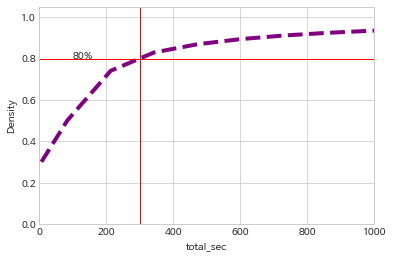

In [131]:
# kdeplot : kernel density estimation 
# density estimation(밀도추정) : (관측된) 데이터들의 분포로부터 원래 변수의 (확률) 분포 특성을 추정하고자 하는 것
# 그러나, 우리가 데이터에 대한 사전 정보를 아는 것은 거의 없기 때문에 사전 정보나 지식 없이 순수하게 관측된 데이터만으로 확률밀도함수를 추정해야 하는데 이를 non-parametric density estimation라 부릅니다.
# non-parametric density estimation의 대표적인 예가 히스토그램인데 히스토그램은 아래와 같이 3가지의 단점이 있습니다. 
# 1) bin의 경계에서 불연속성이 나타난다는 점, 
# 2) bin의 크기 및 시작 위치에 따라서 히스토그램이 달라진다는 점, 
# 3) 고차원(high dimension) 데이터에는 메모리 문제 등으로 사용하기 힘들다는 점 등의 문제점을 갖습니다.
# 이러한 문제점을 해결하기 위한 그래프가 kdeplot입니다. 
# 즉KDE(Kernel Density Estimation)를 통해 얻은 확률밀도함수는 히스토그램 확률밀도함수를 스무딩(smoothing)한 것이 kdeplot입니다. 

plt.xlim(0,1000)
plt.text(100, 0.8, '80%')
sns.kdeplot(df1_action['total_sec'], cumulative=True, color = 'purple', linewidth=4, linestyle='--');
plt.axhline(0.8, linewidth = 1, color = 'red');
plt.axvline(299, linewidth = 1, color = 'red');

plt.show()

평균시간(299초)에 대한 kdeplot을 확인한 결과, 80%를 확인하였습니다. 

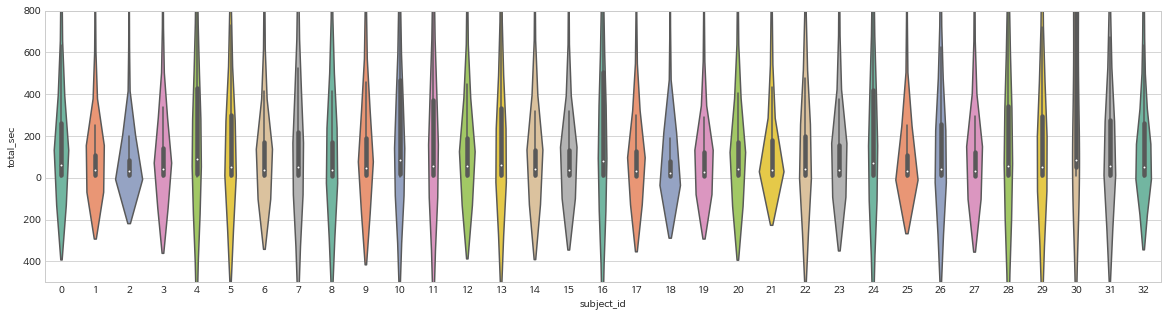

In [132]:
plt.figure(figsize=(20,5))

plt.ylim(-500,800)
sns.violinplot(x = 'subject_id', y='total_sec', data = df1_action.reset_index(), palette="Set2");

plt.show()

참여자별 사용시간에 대한 violinplot을 확인한 결과,  
0~200초 사이 다량의 데이터가 분포하는 것을 관측할 수 있었으며, 얇은 violin 모양을 대부분 관측할 수 있었습니다.   
이를 통해 참여자마다 특정한 앱에서 많은 시간을 소모하는 것이 아닌가 추측해볼 수 있었습니다.

In [133]:
# 일부 앱이 크롤링이 잘못되어 직접 수정을 진행하였습니다. 

# df1_action["genre"][df1_action.name.str.contains("Melon")] = "Music & Audio"
# df1_action["genre_bigcol"][df1_action.name.str.contains("Melon")] = "lifestype"

# df1_action["genre"][df1_action.name.str.contains("삼성 인터넷")] = "Productivity"
# df1_action["genre_bigcol"][df1_action.name.str.contains("삼성 인터넷")] = "producivity"

# df1_action["genre"][df1_action.name.str.contains("Chrome")] = "Productivity"
# df1_action["genre_bigcol"][df1_action.name.str.contains("Chrome")] = "producivity"

# df1_action["genre"][df1_action.name.str.contains("다음")] = "Productivity"
# df1_action["genre_bigcol"][df1_action.name.str.contains("다음")] = "producivity"

# df1_action["genre"][df1_action.name.str.contains("검은사막 모바일")] = "Role Playing"
# df1_action["genre_bigcol"][df1_action.name.str.contains("검은사막 모바일")] = "game"

# df1_action["genre"][df1_action.name.str.contains("YouTube")] = "Video"
# df1_action["genre_bigcol"][df1_action.name.str.contains("YouTube")] = "hobby"

In [134]:
top_ap = df1_action.groupby(['genre_bigcol','name'])['total_sec'].agg(['count','mean'])
top_ap['mean'] = top_ap['mean'].map(lambda x: time.strftime('%H:%M:%S', time.gmtime(x)))
top_ap.sort_values('count', ascending=False).head(10).groupby(level=0).head().sort_index(ascending=False)

count      mean
genre_bigcol     name                                 
tools            TouchWiz 홈             4607  00:06:30
social           트위터                    7223  00:02:42
                 Facebook               4693  00:03:51
self development Samsung Experience 홈  19199  00:05:39
                 ABC Platform           9157  00:05:16
lifestype        캐시워크                   8737  00:10:32
contact          카카오톡                  32331  00:03:24
                 삼성 인터넷                 4859  00:04:53
                 메시지                    4761  00:04:42
                 Chrome                 6386  00:03:55

In [135]:
top_ap[top_ap['count'] >= 100].sort_values('mean', ascending=False).head(10).groupby(level=0).head().sort_index()

count      mean
genre_bigcol name                                      
game         벽람항로                         473  00:12:23
             위베어베어스 더퍼즐                   169  00:13:14
hobby        AfreecaTV                    184  00:12:40
lifestype    CJ ONE                       258  00:16:47
             Mi 피트                        481  00:12:10
producivity  알람/시간                        126  00:37:01
tools        AhnLab V3 Mobile Security    204  00:12:30
             기본홈(홈&앱서랍)                   768  00:12:59
             시계                          1687  00:11:09
             알람/시계                        378  00:12:05

In [136]:
# Counter를 이용하여 인기있는 앱과 장르를 찾아보겠습니다. 
from collections import Counter

app_pt = Counter()
genre_pt = Counter()

a_pat = list(zip(set_df1_action['referrer_app'],set_df1_action['name']))
g_pat = list(zip(set_df1_action['referrer_genre'], set_df1_action['genre']))

app_pt.update(a_pat)
genre_pt.update(g_pat)

In [137]:
# 가장 인기있는 앱 10개를 골라보았습니다. 
app_pt.most_common(10)

[(('Samsung Experience 홈', '카카오톡'), 9439),
 (('카카오톡', 'Samsung Experience 홈'), 5756),
 (('모아락', '캐시워크'), 2324),
 (('시스템 UI', '카카오톡'), 2273),
 (('허니스크린', '캐시워크'), 2064),
 (('ABC Platform', '카카오톡'), 2051),
 (('Samsung Experience 홈', 'NAVER'), 1989),
 (('Samsung Experience 홈', 'Instagram'), 1891),
 (('Samsung Experience 홈', '삼성 인터넷'), 1836),
 (('원더락', '캐시워크'), 1694)]

In [138]:
# 가장 인기있는 장르 10개를 골라보았습니다. 
genre_pt.most_common(10)

[(('Business', 'Communication'), 14918),
 (('Personalization', 'Communication'), 13050),
 (('Communication', 'Business'), 7903),
 (('Communication', 'Communication'), 7179),
 (('Personalization', 'Social'), 6608),
 (('Business', 'Social'), 6143),
 (('Health & Fitness', 'Communication'), 4825),
 (('Lifestyle', 'Health & Fitness'), 4348),
 (('Tools', 'Communication'), 4346),
 (('Communication', 'Personalization'), 4129)]

In [139]:
# 가장 인기있는 장르 100개를 골라서 네트워크를 이용하여 시각화해보겠습니다. 
genre_pt_1000 = genre_pt.most_common(100)

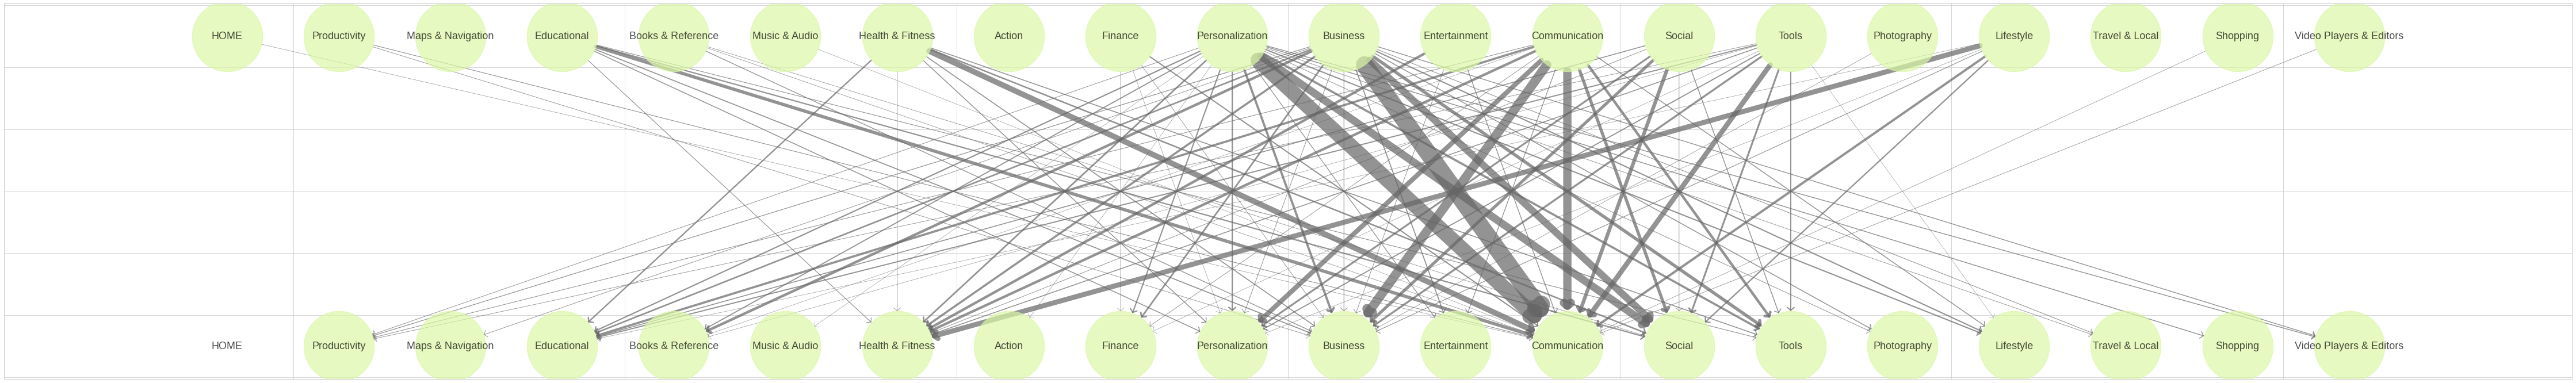

In [140]:
import networkx as nx
import numpy as np

plt.figure(figsize=(80,12))

G1_keys = set([k[0] for k, _ in genre_pt_1000 if all(k) is True])
G2_keys = set([k[1] for k, _ in genre_pt_1000 if all(k) is True])
G_keys = G1_keys.union(G2_keys)
num_keys = len(G_keys)
G_mapping = {k: v for v, k in enumerate(G_keys)}
G_rev_mapping = {k: v for k, v in enumerate(G_keys)}

edge_list = []
for edge, weight in genre_pt_1000:
    if all(edge) is False: continue
    mapped_edge = (G_mapping[edge[0]], G_mapping[edge[1]] + num_keys, weight)
    edge_list.append(mapped_edge)

node_labels = {k: v for k, v in G_rev_mapping.items()}
node_labels.update({k + num_keys: v for k, v in G_rev_mapping.items()})

DG = nx.DiGraph()

DG.add_weighted_edges_from(edge_list)
DG.add_nodes_from([k for k in G_rev_mapping.keys()])

pos = {}
for node in node_labels.keys():
    x_spacing = np.linspace(-0.8, 0.8, num_keys)
    x = x_spacing[node] if node < num_keys else x_spacing[node - num_keys]
    y = 0.5 if node < num_keys else -0.5
    pos[node] = (x, y)

edge_width = [DG[u][v]['weight'] for u, v in DG.edges()]
normalized_edge_width = [30 * width / max(edge_width) for width in edge_width]

plt.figure(1, figsize=(24, 8))
graph = nx.draw_networkx(DG, pos,
                         alpha=0.7,
                         with_labels=True, width=normalized_edge_width,
                         edge_color='.4', node_color = '#DAF7A6', node_size=15000, labels=node_labels, font_size = 18,
                         arrowstyle='->,head_width=0.6,head_length=0.5')

In [141]:
# 가장 인기있는 앱 100개를 골라서 네트워크를 이용하여 시각화해보겠습니다. 
app_pt_100 = app_pt.most_common(100)

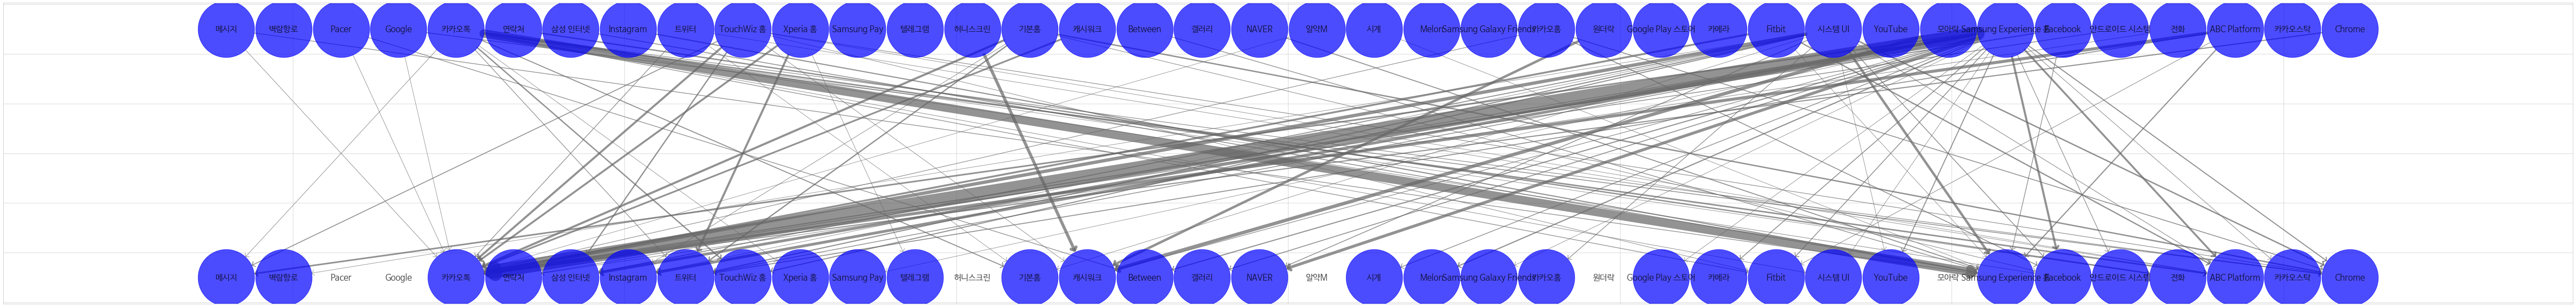

In [142]:
plt.figure(figsize=(100,12))

# zip으로 묶여있는 데이터에서 첫번째 앱과 두번째 앱을 각각 G1_keys과 G2_keys에 넣어주도록 하겠습니다. 
G1_keys = set([k[0] for k, _ in app_pt_100 if all(k) is True])
G2_keys = set([k[1] for k, _ in app_pt_100 if all(k) is True])

# dict G1_keys과 G2_keys을 하나로 통합해주도록 하겠습니다. 
G_keys = G1_keys.union(G2_keys)
num_keys = len(G_keys)
G_mapping = {k: v for v, k in enumerate(G_keys)}
G_rev_mapping = {k: v for k, v in enumerate(G_keys)}

edge_list = []
for edge, weight in app_pt_100:
  # edge는 앱 두개를 묶어놓은 것이고, 
  # weight는 몇번 이러한 숫자들이 있는지를 count한 값입니다. 
  if all(edge) is False: continue
  mapped_edge = (G_mapping[edge[0]], G_mapping[edge[1]] + num_keys, weight)
  edge_list.append(mapped_edge)

node_labels = {k: v for k, v in G_rev_mapping.items()}
node_labels.update({k + num_keys: v for k, v in G_rev_mapping.items()})

DG = nx.DiGraph()

DG.add_weighted_edges_from(edge_list)
DG.add_nodes_from([k for k in G_rev_mapping.keys()])

pos = {}
for node in node_labels.keys():
    x_spacing = np.linspace(-0.8, 0.8, num_keys)
    x = x_spacing[node] if node < num_keys else x_spacing[node - num_keys]
    y = 0.5 if node < num_keys else -0.5
    pos[node] = (x, y)

edge_width = [DG[u][v]['weight'] for u, v in DG.edges()]
normalized_edge_width = [30 * width / max(edge_width) for width in edge_width]

plt.figure(1, figsize=(24, 8))
graph = nx.draw_networkx(DG, pos,
                         alpha=0.7,
                         with_labels=True, width=normalized_edge_width,
                         edge_color='.4', node_color = 'blue', node_size=15000, labels=node_labels, font_size = 18,
                         arrowstyle='->,head_width=0.6,head_length=0.5', font_family="NanumBarunGothic")

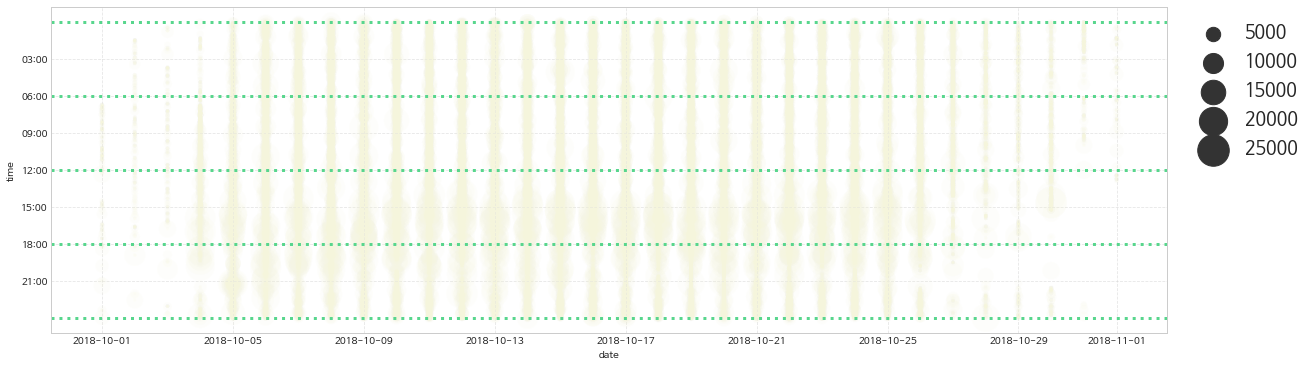

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize = (20,6))

pd.plotting.register_matplotlib_converters()

dt = df1_action.reset_index()[['date','time','total_sec','subject_id']]
# dt = dt.sort_values(by="date", ascending=True)
# dt["time"] = pd.to_datetime(dt["time"])

x = dt.date
y = dt.time
size = dt.total_sec
ytick = [f'{x}:00' for x in range(3,24,3)]
timepoints = ['00:01','06:00','12:00','18:00','23:59']

sns.scatterplot(x = x, y = y, size = size, sizes = (10,1000), alpha = 0.1, color = '#F5F5DC')
plt.grid(True, alpha = 0.5, linestyle = '--')

# plt.xticks(fontsize = 15)
plt.yticks(ytick)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, prop={'size': 18})
for tp in timepoints: plt.axhline(tp, color = '#58D68D', linewidth = 3, linestyle = ':')
plt.show();

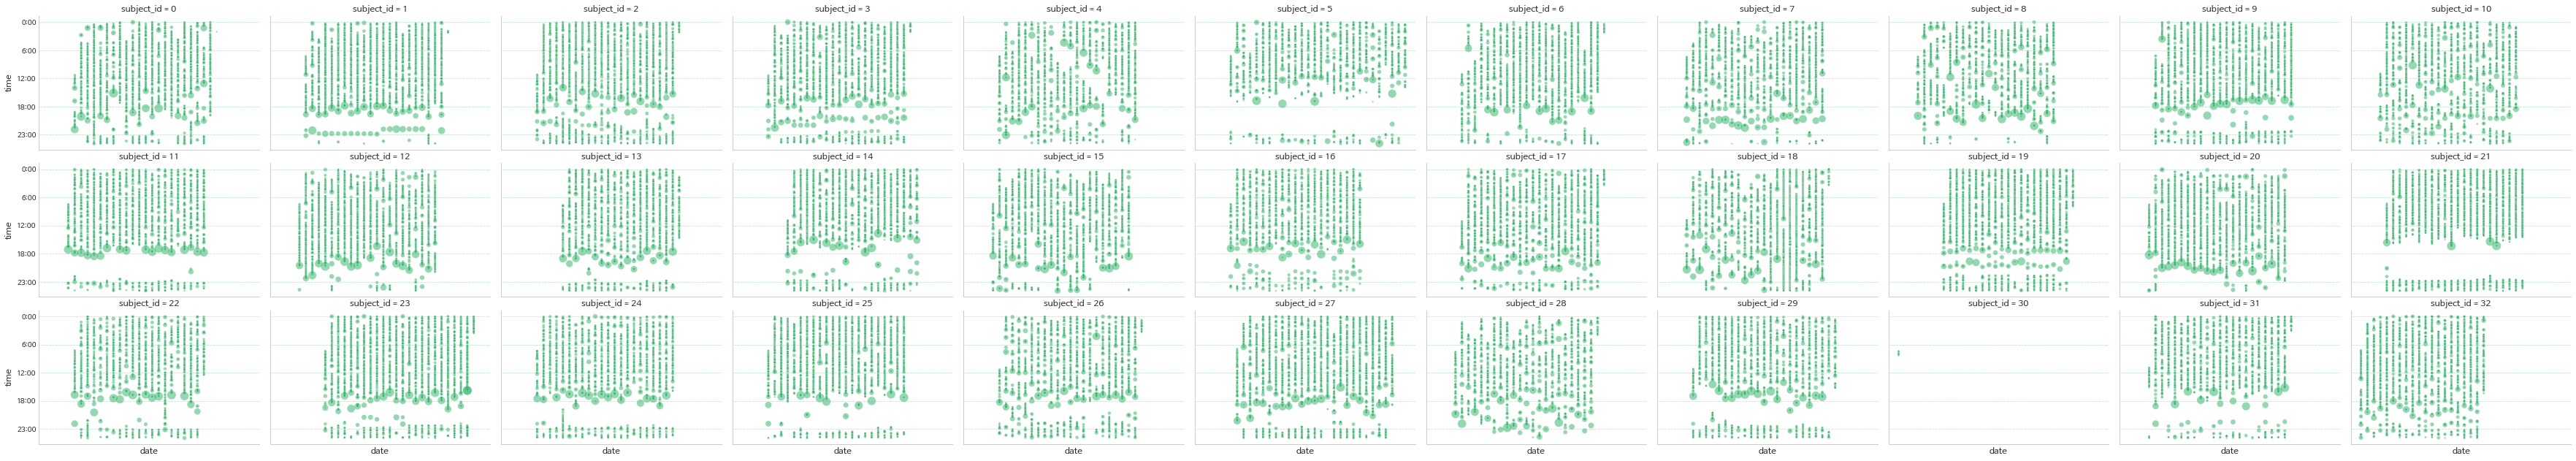

In [144]:
pd.plotting.register_matplotlib_converters()


dt = df1_action.reset_index()[['date','time','total_sec','subject_id']]

g = sns.FacetGrid(dt, col = 'subject_id', col_wrap = 11, aspect = 1.5)
g.map(sns.scatterplot, "date", "time", size = size, sizes = (5,150), color = '#28B463', alpha = 0.5)
ytick = [f'{x}:00' if x!= 24 else '23:00' for x in range(-6,25,6)]

plt.grid(True)
plt.xticks([])
g.fig.subplots_adjust(wspace=.05, hspace=.1)

for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')
    ax.set_yticklabels(ytick, fontsize='medium')
    ax.grid(color='#28B463', linestyle=':', linewidth= 0.5)

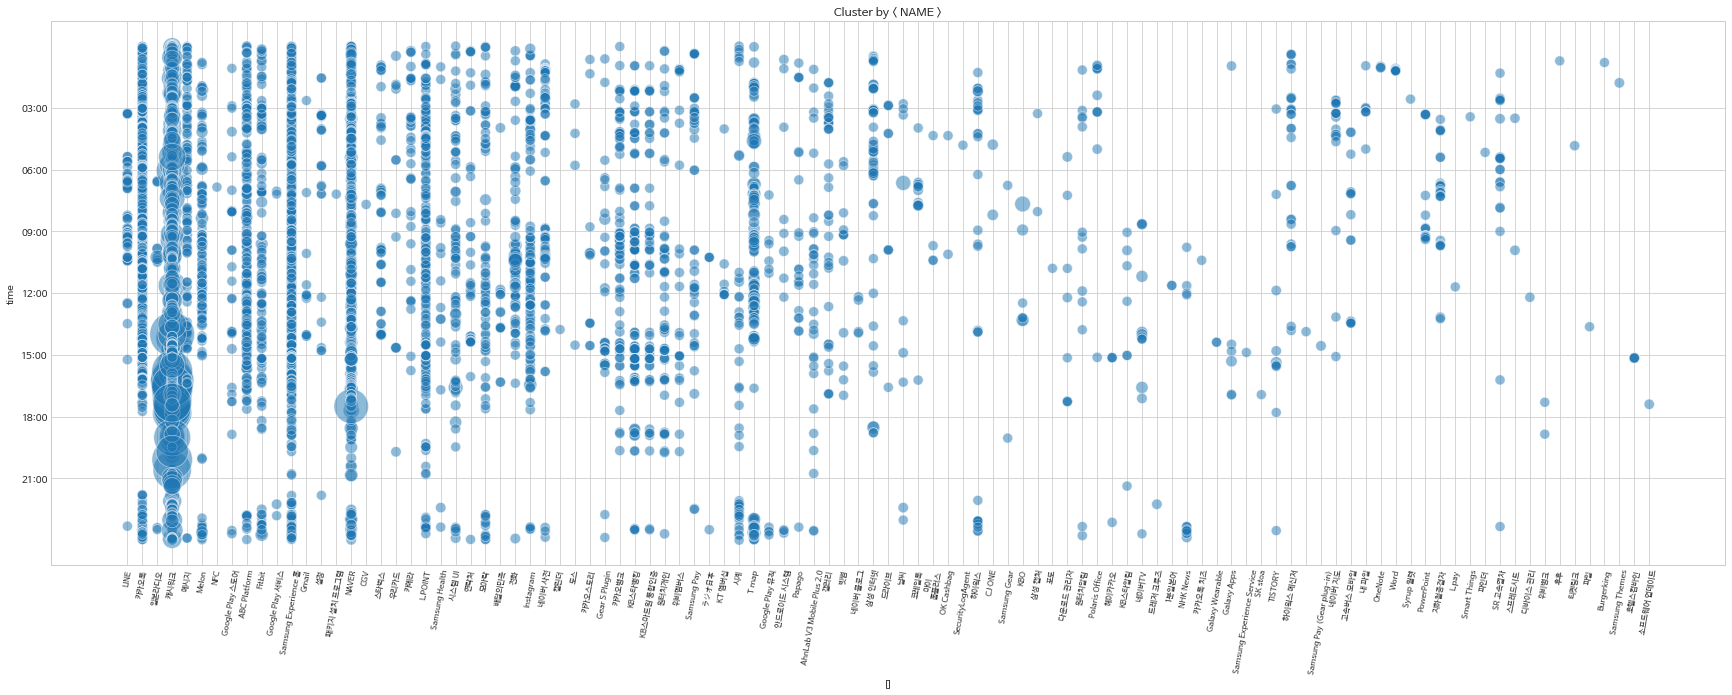

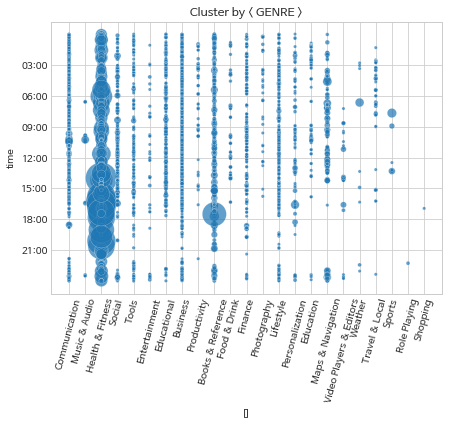

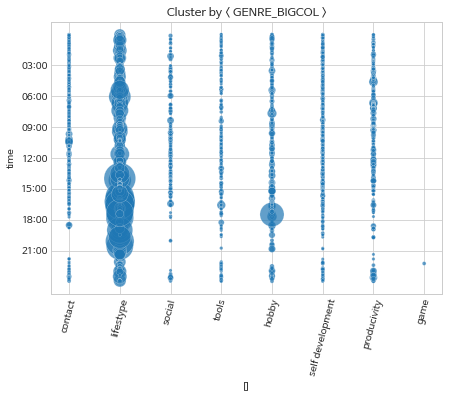

In [145]:
from matplotlib import rc
rc('font', family='NanumBarunGothic') 

pd.plotting.register_matplotlib_converters()

palette = sns.color_palette("Set2",4)
ytick = [f'{x}:00' for x in range(3,24,3)]

df = df1_action.loc[27]

for v in ['name','genre','genre_bigcol']:
    if v == 'name':
        plt.figure(figsize=(30,10));
        plt.xticks(rotation=80, fontsize=8);
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', alpha = 0.5, sizes = (100,2000),
                        data=df, palette= palette, legend = False);
    else:
        plt.figure(figsize=(7,5));
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', alpha = 0.7, sizes = (10,1000),
                        data=df, palette= palette, legend = False);
        plt.xticks(rotation=75)
        
    plt.yticks(ytick)
    plt.title(f'Cluster by < {v.upper()} >')
    plt.xlabel([])
    plt.show();

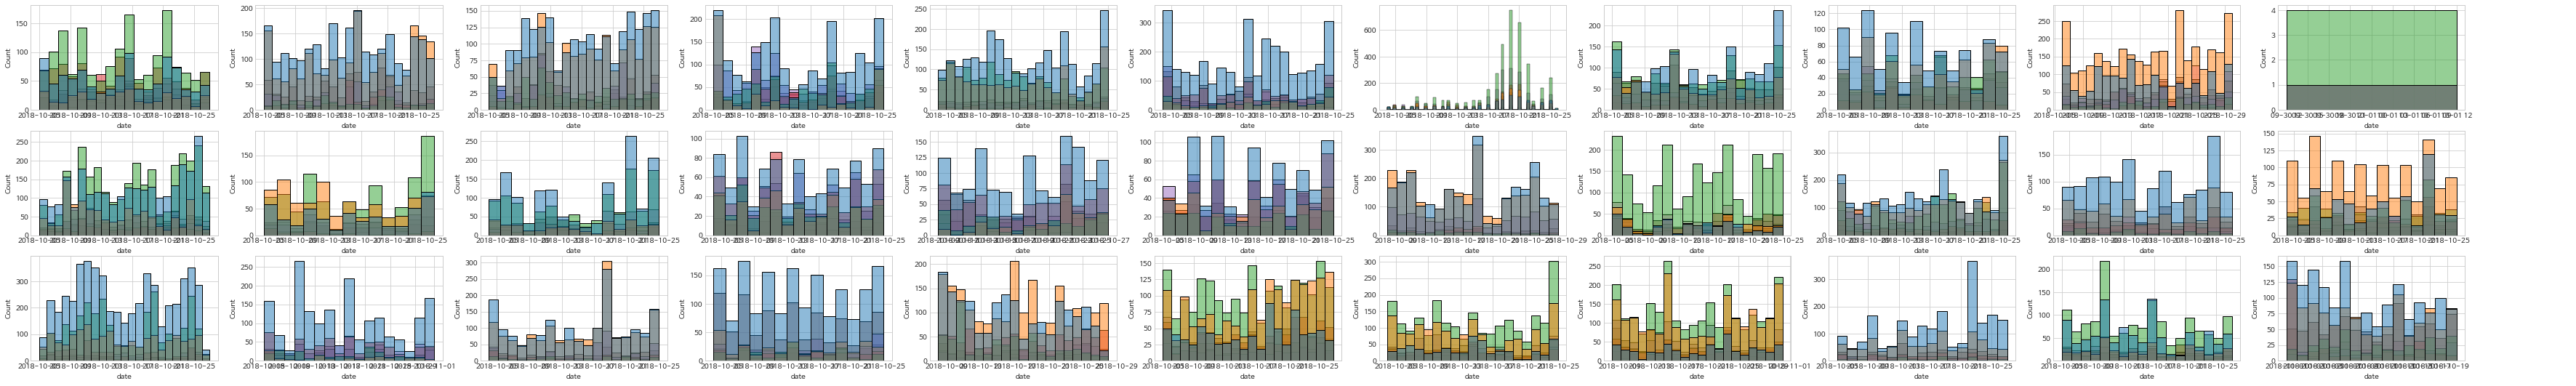

In [146]:
fig = plt.figure(figsize=(60,9))
axes = fig.subplots(nrows=3, ncols=11)

handles = []
labels = df1_action.genre_bigcol.unique()

for i in range(33):
    col = i // 3
    row = i % 3
    
    df = df1_action.loc[i]
    g = sns.histplot(df, x='date', hue='genre_bigcol', ax= axes[row, col], legend = False);
    handles.append(g)

fig.legend(labels, loc="upper right", bbox_to_anchor=[0.935, 0.88], shadow=True, fancybox=True)

plt.show()

In [147]:
# 분명한 사용자의 행동패턴이 관측되었습니다. 
# 이제는 이를 이용하여 importance라는 feature를 만들어보겠습니다. 
# importance라는 = (내가 특정한 앱을 사용하는 시간)/(다른 사용자도 특정한 앱을 사용하는 시간)*(총 이용시간)
my_freq = df1_action.groupby(['subject_id'])['name'].value_counts(normalize=True)
all_freq = df1_action['name'].value_counts(normalize=True)

def cal_importance(row):
    pid = row['subject_id']
    app_name = row['name']
    stay_time = row['total_sec']
    my_impt, all_impt = my_freq.loc[pid][app_name], all_freq[app_name]
    importance = round(my_impt / all_impt, 2)
    importance = importance*(stay_time/60) 
    return importance

In [148]:
df1_action['importance'] = list(df1_action.reset_index().apply(cal_importance, axis=1))

In [149]:
df1_action.importance.max()

20840.079

In [150]:
# 라벨링 하는 작업을 진행하겠습니다. 
def importance_detector(rows):
    time = rows.total_sec
    importance = rows.importance
    
    if (time >= 300) & (importance > 3): return 4
    elif time >= 300: return 3
    elif importance > 3: return 2
    else: return 1

In [151]:
df1_action['importance_cat'] = list(df1_action.apply(importance_detector, axis=1))

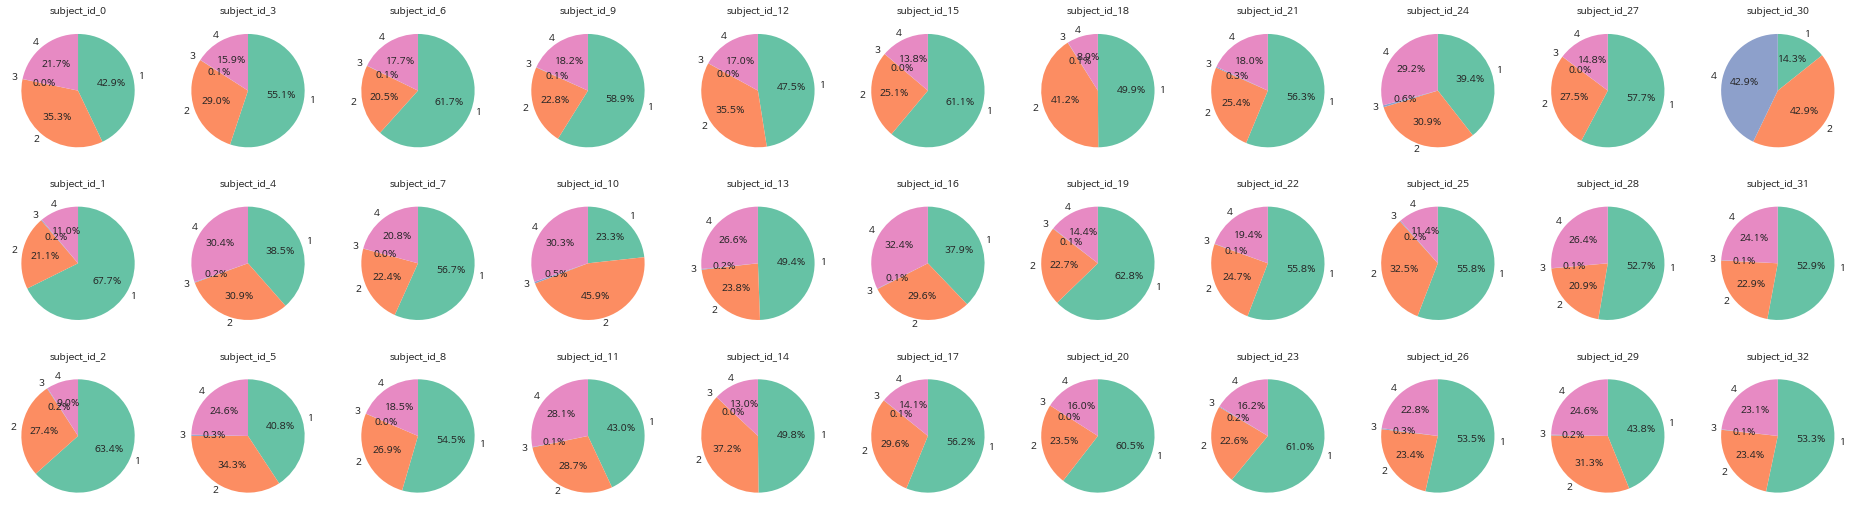

In [152]:
pie_df = pd.DataFrame(df1_action.groupby('subject_id')['importance_cat'].value_counts(normalize=True)).sort_index(level=(0,1)).rename(columns = {'importance_cat':'ratio'})


fig = plt.figure(figsize=(33,9))
axes = fig.subplots(nrows=3, ncols=11)

handles = []
labels = df1_action.genre.unique()
pal = sns.color_palette("Set2", 4)

for i in range(33):
    col = i // 3
    row = i % 3
    
    df = pie_df.loc[i]
    axes[row,col].pie(df['ratio'], labels= df.index, startangle=90, counterclock=False, colors = pal,  autopct='%1.1f%%', textprops={'fontsize':10});
    axes[row,col].set_title(f'subject_id_{i}', fontsize=10)
    

plt.show()

In [153]:
df1_action.groupby('importance_cat')['total_sec'].agg(['mean','count'])

mean   count
importance_cat                     
1                 27.730494  101853
2                109.930503   52664
3                465.146617     266
4               1441.949458   32844

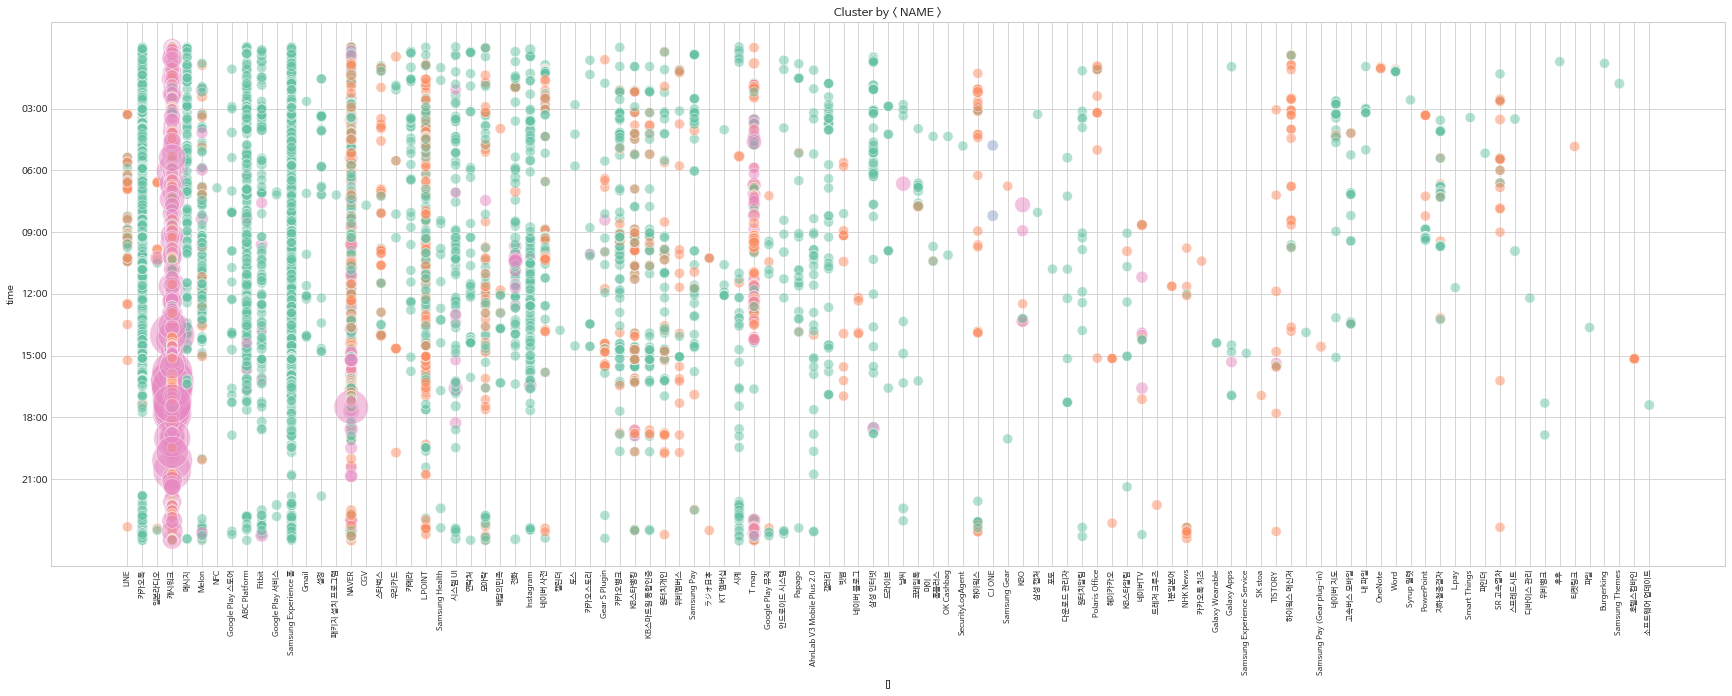

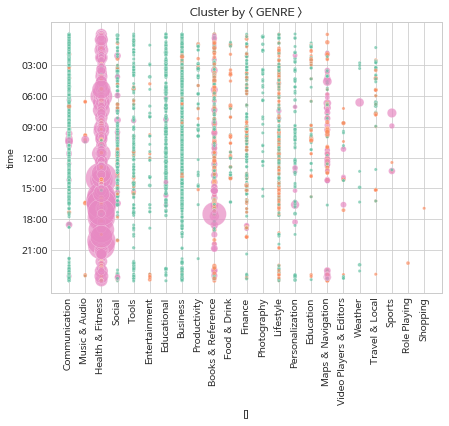

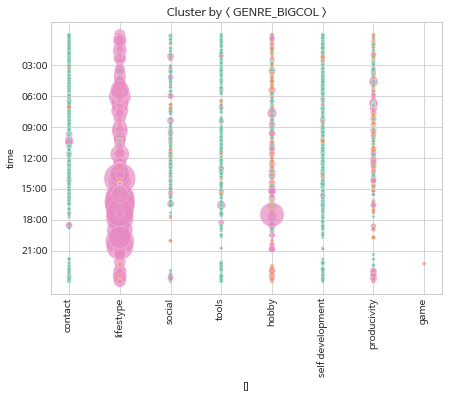

In [154]:
from matplotlib import rc
rc('font', family='NanumBarunGothic') 

pd.plotting.register_matplotlib_converters()

palette = sns.color_palette("Set2",4)
ytick = [f'{x}:00' for x in range(3,24,3)]

df = df1_action.loc[27]

for v in ['name','genre','genre_bigcol']:
    if v == 'name':
        plt.figure(figsize=(30,10));
        plt.xticks(rotation=90, fontsize=8);
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', hue='importance_cat', alpha = 0.5, sizes = (100,2000),
                        data=df, palette= palette, legend = False);
    else:
        plt.figure(figsize=(7,5));
        sns.scatterplot(x= v, y = 'time', size = 'total_sec', hue='importance_cat', alpha = 0.7, sizes = (10,1000),
                        data=df, palette= palette, legend = False);
        plt.xticks(rotation=90)
        
    plt.yticks(ytick)
    plt.title(f'Cluster by < {v.upper()} >')
    plt.xlabel([])
    plt.show();

## ⌨️모델링

##### ML(LGBMClassifier)

사용자의 행동패턴을 기반으로 다음에 사용할 대장르가 무엇인지 예측해보는 모델을 구성해보았습니다. 


- Target
  - genre_bigcol
  - 다음에 사용할 genre_bigcol를 예측  

- Scoring 
  - 성능 : 98.5% 
  - 측정지표 : f1_score
  - 사유 : precision과 recall score를 함께 보는 것이 중요하기 때문에 

- Train:
  - hold out validation 방식으로 Train / val / test 나누어 검증 진행 
  - (train_test_split은 시계열 특성으로 사용불가 )

- Model
  - type : lightGBMRegressor 
  - 사유 : 경량화된 모델로 빠르게 작동하기에 해당 모델을 선택함 



In [155]:
train = df1_action.reset_index()[['subject_id','name','is_system_app','genre','genre_bigcol', 'time','referrer_app','referrer_genre','total_sec','importance_cat']]
train.dropna(inplace = True)

In [156]:
#시계열 data, 이후의 데이터를 예측

val_len = int(len(train)*0.1)
target = ['genre_bigcol'] #다음으로 올 genre는?

y_train = train[target]
x_train = train.drop(target, axis = 1)

x_val = x_train.iloc[(val_len)*-2:]
y_val = y_train.iloc[(val_len)*-2:]

x_train = x_train.drop(x_val.index)
y_train = y_train.drop(y_val.index)

In [157]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((150088, 9), (150088, 1), (37520, 9), (37520, 1))

In [158]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 4.9 MB/s 


In [159]:
import category_encoders
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

In [160]:
pipe = make_pipeline(
    OrdinalEncoder(),
    MultiOutputClassifier(LGBMClassifier(
                                        objective = 'multiclass', # 다중클래스 분류를 위해 multiclass 선정 
                                        metric = 'multi_logloss' # # 다중클래스 분류를 위해 multi_logloss 선정  
                                        ))
)

In [161]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['name', 'genre', 'time', 'referrer_app',
                                      'referrer_genre'],
                                mapping=[{'col': 'name',
                                          'data_type': dtype('O'),
                                          'mapping': Samsung Experience 홈        1
쏠캘린더                        2
Samsung Galaxy Friends      3
삼성 인터넷                      4
리마인더                        5
                         ... 
LFmall                    636
할리스커피                     637
굿모닝 스페인어 사전               638
비디오 에디터 Lite              639
NaN                        -2
Length: 640, dtype: int64},
                                         {'col': 'genre',
                                          'data_type': dtype('O'),
                                          'mapping': Busine...
Arcade                     24
Music & Audio              25
Role Playing               26
News & Magazines

In [162]:
y_pred = pipe.predict(x_val)

In [163]:
## 전체 predict
print(classification_report(y_val, y_pred))

                  precision    recall  f1-score   support

         contact       1.00      1.00      1.00     10262
            game       1.00      0.91      0.95       142
           hobby       0.97      1.00      0.99      2911
       lifestype       1.00      1.00      1.00      4958
     producivity       1.00      0.91      0.95      3058
self development       0.97      1.00      0.99      7780
          social       1.00      1.00      1.00      5194
           tools       1.00      1.00      1.00      3215

        accuracy                           0.99     37520
       macro avg       0.99      0.98      0.98     37520
    weighted avg       0.99      0.99      0.99     37520



##### ML(LGBMRegressor)

사용자 어플리케이션을 얼마나 이용했는지 시간을 예측하는 모델링을 구성해보았습니다. 


- Target
  - totel_sec(총 사용시간 / 단위 : 초)
  - 어플리케이션 사용 시간 예측해보고자 함 

- Scoring 
  - 오류 : 1% 
  - 측정지표 : neg_mean_absolute_percentage_error
  - 사유 : 오차를 비율단위로 측정하기 위해서 

- Train:
  - hold out validation 방식으로 Train / val / test 나누어 검증 진행 
  - (train_test_split은 시계열 특성으로 사용불가 )

- Model
  - type : lightGBMRegressor 



In [164]:
train = df1_action.reset_index()[['subject_id','name','is_system_app','time','genre','genre_bigcol','referrer_app','referrer_genre','importance_cat', 'total_sec']]
train.dropna(inplace = True)

In [165]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

pipe = make_pipeline(
    OrdinalEncoder(),
    LGBMRegressor(
    )   
)

In [166]:
val_len = int(len(train)*0.1)
target = 'total_sec' #다음으로 올 genre는?

y_train = train[target]
X_train = train.drop(target, axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# xgboost ValueError: feature_names mismatch 해결하기 위한 코드 
X_train = np.asmatrix(X_train)
X_val = np.asmatrix(X_val)

In [167]:
val_len*-2

-37520

In [168]:
y_train = train[target]
x_train = train.drop(target, axis = 1)

x_val = x_train.iloc[(val_len)*-2:] # 시계열 데이터이므로 뒤어서부터 순차적으로 가져오기 위한 코드 
y_val = y_train.iloc[(val_len)*-2:]

x_train = x_train.drop(x_val.index)
y_train = y_train.drop(y_val.index)

In [169]:
# X_train.shape, y_train.shape, X_val.shape, y_val.shape
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((150088, 9), (150088,), (37520, 9), (37520,))

In [170]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['name', 'time', 'genre', 'genre_bigcol',
                                      'referrer_app', 'referrer_genre'],
                                mapping=[{'col': 'name',
                                          'data_type': dtype('O'),
                                          'mapping': Samsung Experience 홈        1
쏠캘린더                        2
Samsung Galaxy Friends      3
삼성 인터넷                      4
리마인더                        5
                         ... 
LFmall                    636
할리스커피                     637
굿모닝 스페인어 사전               638
비디오 에디터 Lite              639
NaN                        -2
Length: 640, dtype: int64},
                                         {'col': 'time',
                                          'data_type': dtype('O'),
                                          'm...
Photography                17
Food & Drink               18
Weather                    19
Travel & Local  

In [171]:
y_pred = pipe.predict(x_val)

In [172]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics

k = 10 # 3-fold 교차검증을 수행
scores = cross_val_score(pipe, x_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_percentage_error') #evaluation metrics 설정

## 본래 사용 시간이 300분인 것을 310분으로 예상하는 것과, 1초만에 끝날 것을 1분이라 예상하는 것은 엄연히 다르다.
## 이에 크기 기반이 아닌, 비율을 기반으로 한 예측이 필요 -> neg_mean_absolute_percentage_error로 선정


In [173]:
-scores

array([1.76706453, 1.34898152, 1.63843356, 1.50996709, 2.02761232,
       1.54551609, 1.64614548, 1.79072192, 1.50466862, 2.3589861 ])

In [174]:
-scores.mean()

1.7138097231692853

In [175]:
from sklearn.model_selection import cross_val_score

k = 10 # 3-fold 교차검증을 수행
scores = cross_val_score(pipe, x_val, y_val, cv=k, 
                         scoring='neg_mean_absolute_percentage_error') #evaluation metrics 설정

# 시계열 데이터를 다루고 있는 상황이기에 
# 5분에서 1분 오차와 30분에서 1분 오차는 매우 다른 의미를 결론을 도출하게 된다. 
# 이에, 값의 크기보다 비율적인 scoring이 필요하다고 생각하였고, neg_mean_absolute_percentage_error를 scoring으로 설정하게 되었습니다. 


In [176]:
-scores #오차범위 6~7.5% 사이를 기록하며 꽤 좋은 성능을 보임

array([1.47501468, 1.5796636 , 1.63931738, 1.77619459, 1.72196029,
       1.7626819 , 2.21817271, 2.09054988, 1.81317079, 1.91023072])

In [177]:
-scores.mean()

1.7986956531203322

In [178]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(pipe, x_train, y_train, cv=k,
                            scoring='neg_mean_absolute_percentage_error',
                            return_estimator=True)
# return_estimator의 feault는 False 입니다. / True로 설정하면 각각 cv에 대한 내용이 객체로 출력이 되게 됩니다. 
# 아래에 cv_result['estimator']를 reg_fit로 저장하기위해 return_esitmator를 사용합니다. 

In [179]:
-cv_result['test_score'].mean()

1.7138097231692853

In [180]:
reg_fit = cv_result['estimator']
len(reg_fit) #3cross validation이니까 3개여야함

10

In [181]:
reg_fit

[Pipeline(steps=[('ordinalencoder',
                  OrdinalEncoder(cols=['name', 'time', 'genre', 'genre_bigcol',
                                       'referrer_app', 'referrer_genre'],
                                 mapping=[{'col': 'name',
                                           'data_type': dtype('O'),
                                           'mapping': Samsung Experience 홈        1
 쏠캘린더                        2
 Samsung Galaxy Friends      3
 삼성 인터넷                      4
 리마인더                        5
                          ... 
 LFmall                    636
 할리스커피                     637
 굿모닝 스페인어 사전               638
 비디오 에디터 Lite              639
 NaN                        -2
 Length: 640, dtype: int64},
                                          {'col': 'time',
                                           'data_type': dtype('O'),
                                           'm...
 Photography                17
 Food & Drink               18
 Weather                

In [182]:
%store reg_fit

Stored 'reg_fit' (list)
